<a href="https://www.kaggle.com/code/redpen12/agentic-rag-with-langgraph-and-groq-llama-3?scriptVersionId=177251306" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="
  font-size: 3em;
  color: #333;
  text-align: center;
  background-color: #f2f2f2;
  padding: 20px;
  border-radius: 10px;
  margin: 40px;
  animation: fadeIn 1s ease-in-out;
">Agentic RAG with LangGrapgh 🎉</h1>

<div style="background-color: #f9f9f9; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
  <p style="font-size: 16px; line-height: 1.6; color: #555;">
    In this notebook, I built a RAG (Retrieval Augmented Generation) system to answer medical queries. The agent's primary duty is to fetch chunks from a vector store to answer a user's query. However, the retrieved chunks are not just given as-is to the language model (LLM). They are first scored, and only the chunks that are relevant to the query are passed to the LLM.
  </p>
  <p style="font-size: 16px; line-height: 1.6; color: #555;">
    In cases where all the retrieved chunks are not relevant to the query, the agent performs a web search. The agent also performs a web search for queries that do not have any relevant documents in the vector store.
  </p>
  <p style="font-size: 16px; line-height: 1.6; color: #555;">
    Before the LLM's response is presented to the user, the system performs a hallucination and answer relevance check. Lastly, if the query is not related to health, the system falls back to a different chain to respond based on its knowledge.
  </p>
  <h3 style="color: #333; margin-top: 30px;">Stack Used:</h3>
  <ul style="font-size: 16px; line-height: 1.6; color: #555; list-style-type: none; padding-left: 0;">
    <li>- Chromadb</li>
    <li>- DuckDuckGo</li>
    <li>- HuggingFaceHubEmbeddings (sentence-transformers/all-mpnet-base-v2)</li>
    <li>- Mixtral 8x7B from Groq</li>
    <li>- Langchain and LangGraph</li>
    <li>- Gradio</li>
  </ul>
</div>

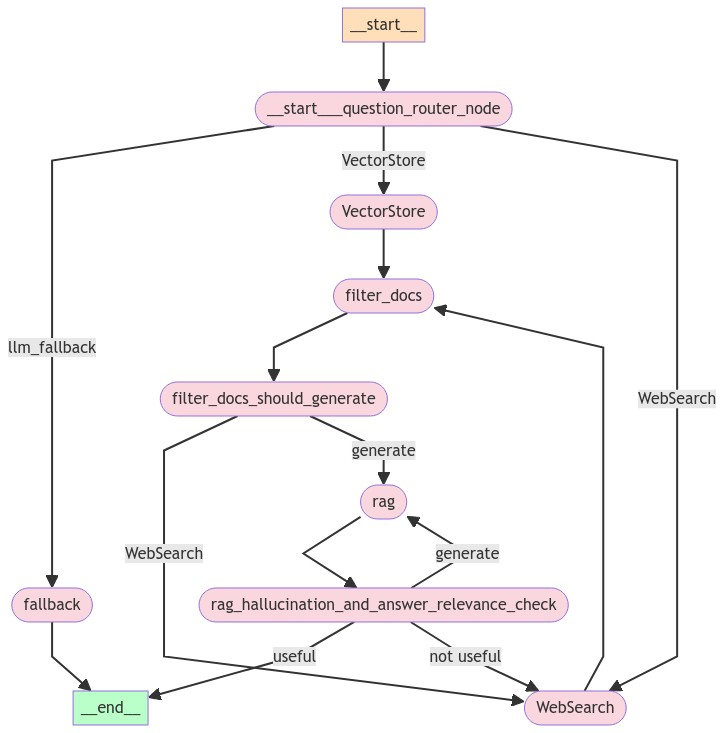

<h1 style="
  font-size: 2em;
  color: #333;
  background-color: #f2f2f2;
  padding: 15px;
  border-radius: 10px;
  margin: 20px;
  animation: fadeIn 1s ease-in-out;
  width: 420px;
">1. Importing relevant libraries</h1>

In [153]:
!pip install -qU langchain\
    langchain-community\
    langchain-groq\
    langchain-core\
    gpt4all\
    langgraph\
    chromadb\
    sentence-transformers\
    tavily-python\
    gradio

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [154]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import nest_asyncio
from langchain_community.vectorstores.chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq.chat_models import ChatGroq
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal
from langchain.chains.combine_documents import stuff
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from IPython.core.display import Markdown
import json
import re
from langchain_core.runnables import (
    RunnableParallel,
    RunnableBranch,
    RunnablePassthrough,
)
from langchain_core.messages import HumanMessage, AIMessage
from operator import itemgetter
import asyncio

<h1 style="
  font-size: 2em;
  color: #333;
  background-color: #f2f2f2;
  padding: 15px;
  border-radius: 10px;
  margin: 20px;
  animation: fadeIn 1s ease-in-out;
  width: 400px;
">2. Set Environment Variables</h1>

In [155]:
from kaggle_secrets import UserSecretsClient
import os
user_secrets = UserSecretsClient()
GROQ_API_KEY = user_secrets.get_secret("GROQ_API_KEY")
LANGCHAIN_API_KEY = user_secrets.get_secret("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = user_secrets.get_secret("LANGCHAIN_PROJECT")
TAVILY_API_KEY = user_secrets.get_secret("TAVILY_API_KEY")

os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]=LANGCHAIN_API_KEY
os.environ["LANGCHAIN_PROJECT"]="Agentic RAG"
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

### Utility Function

In [156]:
def parse_search_research(results: str):
    pattern = r"\[content: (.*?), title: (.*?), url: (.*?)\]"
    result = re.findall(pattern, results)

    data_list = []
    for snippet, title, link in result:
        data_list.append({"content": snippet, "title": title, "url": link})
    return data_list

<h1 style="
  font-size: 2em;
  color: #333;
  background-color: #f2f2f2;
  padding: 15px;
  border-radius: 10px;
  margin: 20px;
  animation: fadeIn 1s ease-in-out;
  width: 600px;
">3. Preparing and Storing Data in Vector Store.</h1>

In [157]:
urls = [
    "https://www.webmd.com/a-to-z-guides/malaria",
    "https://www.webmd.com/diabetes/type-1-diabetes",
    "https://www.webmd.com/diabetes/type-2-diabetes",
    "https://www.webmd.com/migraines-headaches/migraines-headaches-migraines",
]

loader = WebBaseLoader(urls, bs_get_text_kwargs={"strip": True})
docs = loader.load()

In [158]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
chunks = text_splitter.split_documents(docs)

embedding_function = HuggingFaceEmbeddings(show_progress=True, multi_process=True)

vector_store = Chroma.from_documents(documents=chunks, embedding=embedding_function)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [159]:
# retriever.get_relevant_documents("Symptoms of migraine")

<div style="
  font-size: 1em;
  color: #333;
  background-color: #f2f2f2;
  padding: 10px;
  border-radius: 10px;
  margin: 20px;
  animation: fadeIn 1s ease-in-out;
  width: 500px;
">
    <h1>4. Question Router Chain.</h1>
    <p style="font-size: 1.2em;"
        >This will direct the user's query to one of the following: a vector store, a web search engine, or neither (None).</p> 
</div>

In [160]:
class VectorStore(BaseModel):
    (
        "A vectorstore contains information about symptoms, treatment"
        ", risk factors and other information about malaria, type 1 and"
        "type 2 diabetes and migraines"
    )

    query: str


class SearchEngine(BaseModel):
    """A search engine for searching other medical information on the web"""

    query: str

class SearchEngine(BaseModel):
    """A search engine for searching other medical information on the web"""

    query: str

router_prompt_template = (
    "You are an expert in routing user queries to either a VectorStore, SearchEngine\n"
    "Use SearchEngine for all other medical queries that are not related to malaria, diabetes, or migraines.\n"
    "The VectorStore contains information on malaria, diabetes, and migraines.\n"
    'Note that if a query is not medically-related, you must output "not medically-related", don\'t try to use any tool.\n\n'
    "query: {query}"
)

llm = ChatGroq(model="Llama3-70b-8192", temperature=0)
prompt = ChatPromptTemplate.from_template(router_prompt_template)
question_router = prompt | llm.bind_tools(tools=[VectorStore, SearchEngine])

In [161]:
response = question_router.invoke("What are the symptoms of chest pain?")
"tool_calls" in response.additional_kwargs

True

In [162]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mnqf', 'function': {'arguments': '{"query":"What are the symptoms of chest pain?"}', 'name': 'SearchEngine'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_time': 0.217, 'completion_tokens': 66, 'prompt_time': 0.471, 'prompt_tokens': 1083, 'queue_time': None, 'total_time': 0.688, 'total_tokens': 1149}, 'model_name': 'Llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-228ad80a-f062-4d09-a900-74a968b50570-0', tool_calls=[{'name': 'SearchEngine', 'args': {'query': 'What are the symptoms of chest pain?'}, 'id': 'call_mnqf'}])

<div style="
  font-size: 1em;
  color: #333;
  background-color: #f2f2f2;
  padding: 10px;
  border-radius: 10px;
  margin: 20px;
  animation: fadeIn 1s ease-in-out;
  width: 600px;
">
    <h1>5. Retrieved Documents Relevance Grader</h1>
    <p style="font-size: 1.2em;"
        >This is to make sure we filter the documents down so that only the relevant chunks are used as context and not the entire retrieved chunks.</p> 
</div>

In [163]:
from langchain_core.pydantic_v1 import validator


class Grader(BaseModel):
    "Use this format to give a binary score for relevance check on retrived documents."

    grade: Literal["relevant", "irrelevant"] = Field(
        ...,
        description="The relevance score for the document.\n"
        "Set this to 'relevant' if the given context is relevant to the user's query, or 'irrlevant' if the document is not relevant.",
    )

    @validator("grade", pre=True)
    def validate_grade(cls, value):
        if value == "not relevant":
            return "irrelevant"
        return value


grader_system_prompt_template = """"You are a grader tasked with assessing the relevance of a given context to a query. 
    If the context is relevant to the query, score it as "relevant". Otherwise, give "irrelevant".
    Do not answer the actual answer, just provide the grade in JSON format with "grade" as the key, without any additional explanation."
    """

grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grader_system_prompt_template),
        ("human", "context: {context}\n\nquery: {query}"),
    ]
)


grader_chain = grader_prompt | llm.with_structured_output(Grader, method="json_mode")

query = "symptoms of migraine"
context = retriever.get_relevant_documents(query)

response = grader_chain.invoke({"query": query, "context": context})

In [164]:
print(response)

grade='relevant'


In [165]:
query = "Treatment of Ulcer"
context = retriever.get_relevant_documents(query)

response = grader_chain.invoke({"query": query, "context": context})
print(response)

grade='irrelevant'


<div style="
  font-size: 1em;
  color: #333;
  background-color: #f2f2f2;
  padding: 10px;
  border-radius: 10px;
  margin: 20px;
  animation: fadeIn 1s ease-in-out;
  width: 500px;
">
    <h1>5. RAG Chain</h1>
    <p style="font-size: 1.2em;"
        >Responding to the user's query based on the filtered chunks</p> 
</div>

In [166]:
rag_template_str = (
    "You are a helpful assistant. Answer the query below based only on the provided context.\n\n"
    "context: {context}\n\n"
    "query: {query}"
)


rag_prompt = ChatPromptTemplate.from_template(rag_template_str)
rag_chain = rag_prompt | llm | StrOutputParser()

query = "What are the symptoms of malaria?"
context = retriever.get_relevant_documents(query)

response = rag_chain.invoke({"query": query, "context": context})

Markdown(response)

According to the provided context, the symptoms of malaria include:

1. Impaired consciousness
2. Convulsions
3. Difficulty breathing
4. Serious tiredness and fatigue
5. Dark or bloody urine
6. Yellow eyes and skin (jaundice)
7. Abnormal bleeding

If you have any of these symptoms, it is recommended to go to the ER right away.

<div style="
  font-size: 1em;
  color: #333;
  background-color: #f2f2f2;
  padding: 10px;
  border-radius: 10px;
  margin: 20px;
  animation: fadeIn 1s ease-in-out;
  width: 500px;
">
    <h1>6. Fallback Chain</h1>
    <p style="font-size: 1.2em;"
        >This chain is responsible for handling situations where the agent does not call a tool bacause calling a tool is not relevant.</p> 
</div>

In [167]:
fallback_prompt = ChatPromptTemplate.from_template(
    (
        "You are a friendly medical assistant created by RedxAI.\n"
        "Do not respond to queries that are not related to health.\n"
        "If a query is not related to health, acknowledge your limitations.\n"
        "Provide concise responses to only medically-related queries.\n\n"
        "Current conversations:\n\n{chat_history}\n\n"
        "human: {query}"
    )
)

fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                (
                    f"human: {msg.content}"
                    if isinstance(msg, HumanMessage)
                    else f"AI: {msg.content}"
                )
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query") ,
    }
    | fallback_prompt
    | llm
    | StrOutputParser()
)

fallback_chain.invoke(
    {
        "query": "Hello",
        "chat_history": [],
    }
)

"Hello! I'm happy to help with any medical-related questions or concerns you may have. What's on your mind today?"

<div style="
  font-size: 1em;
  color: #333;
  background-color: #f2f2f2;
  padding: 10px;
  border-radius: 10px;
  margin: 20px;
  animation: fadeIn 1s ease-in-out;
  width: 720px;
">
    <h1>7. Hallucination and Answer Relevance Assessment</h1>
    <p style="font-size: 1.2em;"
        >In the final step, we use the <strong>LLM</strong> to evaluate whether its response is a hallucination or not, based on the
        response itself and the provided context. If the response is not derived from the given context, it is marked as a hallucination.
        Once the hallucination check is passed, the user's query and the LLM's response are then assessed to determine if the response
        relevant to the query.<br><br>
        If the response is identified as a hallucination, we go back to the <strong>RAG chain</strong>. If the response is not
        hallucination, but the answer relevance check fails, we perform a web search. Otherwise, we return the LLM's response to the user
    </p> 
</div>

In [168]:
class HallucinationGrader(BaseModel):
    "Binary score for hallucination check in llm's response"

    grade: Literal["yes", "no"] = Field(
        ..., description="'yes' if the llm's reponse is hallucinated otherwise 'no'"
    )


hallucination_grader_system_prompt_template = (
    "You are a grader assessing whether a response from an llm is based on a given context.\n"
    "If the llm's response is not based on the given context give a score of 'yes' meaning it's a hallucination"
    "otherwise give 'no'\n"
    "Just give the grade in json with 'grade' as a key and a binary value of 'yes' or 'no' without additional explanation"
)

hallucination_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_grader_system_prompt_template),
        ("human", "context: {context}\n\nllm's response: {response}"),
    ]
)


hallucination_grader_chain = (
    RunnableParallel(
        {
            "response": itemgetter("response"),
            "context": lambda x: "\n\n".join([c.page_content for c in x["context"]]),
        }
    )
    | hallucination_grader_prompt
    | llm.with_structured_output(HallucinationGrader, method="json_mode")
)

query = "Symptoms of malaria"
context = retriever.get_relevant_documents(query)
response = """Based on the context provided, the symptoms of malaria include: Impaired consciousness, Convulsions, Difficulty breathing,
Serious tiredness and fatigue, Dark or bloody urine, Yellow eyes and skin (jaundice), Abnormal bleeding, High fever, Chills,
Sweating, Nausea or vomiting, Headache, Diarrhea"""

response = hallucination_grader_chain.invoke({"response": response, "context": context})

In [169]:
response

HallucinationGrader(grade='yes')

In [170]:
class AnswerGrader(BaseModel):
    "Binary score for an answer check based on a query."

    grade: Literal["yes", "no"] = Field(
        ...,
        description="'yes' if the provided answer is an actual answer to the query otherwise 'no'",
    )


answer_grader_system_prompt_template = (
    "You are a grader assessing whether a provided answer is in fact an answer to the given query.\n"
    "If the provided answer does not answer the query give a score of 'no' otherwise give 'yes'\n"
    "Just give the grade in json with 'grade' as a key and a binary value of 'yes' or 'no' without additional explanation"
)

answer_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_system_prompt_template),
        ("human", "query: {query}\n\nanswer: {response}"),
    ]
)


answer_grader_chain = answer_grader_prompt | llm.with_structured_output(
    AnswerGrader, method="json_mode"
)

query = "Symptoms of malaria"
# context = retriever.get_relevant_documents(query)
response = """Based on the context provided, the symptoms of malaria include: Impaired consciousness, Convulsions, Difficulty breathing,
Serious tiredness and fatigue, Dark or bloody urine, Yellow eyes and skin (jaundice), Abnormal bleeding, High fever, Chills,
Sweating, Nausea or vomiting, Headache, Diarrhea"""

response = answer_grader_chain.invoke({"response": response, "query": query})

In [171]:
response

AnswerGrader(grade='yes')

<div style="
  font-size: 1em;
  color: #333;
  background-color: #f2f2f2;
  padding: 10px;
  border-radius: 10px;
  margin: 20px;
  animation: fadeIn 1s ease-in-out;
  width: 500px;
">
    <h1>8. Defining the Agent's Workflow</h1>
</div>

In [185]:
from typing import TypedDict, Annotated
from langchain_core.documents import Document
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.prebuilt import ToolInvocation, ToolExecutor
from langchain_core.tools import Tool
from langchain_core.messages.base import BaseMessage
import operator

ddg_search = DuckDuckGoSearchResults(max_results=4)
tavily_search = TavilySearchResults()
tool_executor = ToolExecutor(
    tools=[
        Tool(
            name="VectorStore",
            func=retriever.invoke,
            description="Useful to search the vector database",
        ),
        Tool(
            name="SearchEngine", func=ddg_search, description="Useful to search the web"
        ),
    ]
)


class AgentSate(TypedDict):
    """The dictionary keeps track of the data required by the various nodes in the graph"""

    query: str
    chat_history:list[BaseMessage]
    generation: str
    documents: list[Document]


def retrieve_node(state: dict) -> dict[str, list[Document] | str]:
    """
    Retrieve relevent documents from the vectorstore

    query: str

    return list[Document]
    """
    query = state["query"]
    documents = retriever.invoke(input=query)
    return {"documents": documents}


def fallback_node(state: dict):
    """
    Fallback to this node when there is no tool call
    """
    query = state["query"]
    chat_history = state["chat_history"]
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history})
    return {"generation": generation}


def filter_documents_node(state: dict):
    filtered_docs = list()

    query = state["query"]
    documents = state["documents"]
    for i, doc in enumerate(documents, start=1):
        grade = grader_chain.invoke({"query": query, "context": doc})
        if grade.grade == "relevant":
            print(f"---CHUCK {i}: RELEVANT---")
            filtered_docs.append(doc)
        else:
            print(f"---CHUCK {i}: NOT RELEVANT---")
    return {"documents": filtered_docs}


def rag_node(state: dict):
    query = state["query"]
    documents = state["documents"]

    generation = rag_chain.invoke({"query": query, "context": documents})
    return {"generation": generation}


def web_search_node(state: dict):
    query = state["query"]
    results = tavily_search.invoke(query)
    # results = parse_search_research(results)
    documents = [
        Document(page_content=doc["content"], metadata={"source": doc["url"]})
        for doc in results
    ]
    return {"documents": documents}


def question_router_node(state: dict):
    query = state["query"]
    try:
        response = question_router.invoke({"query": query})
    except Exception:
        return "llm_fallback"

    if "tool_calls" not in response.additional_kwargs:
        print("---No tool called---")
        return "llm_fallback"

    if len(response.additional_kwargs["tool_calls"]) == 0:
        raise "Router could not decide route!"

    route = response.additional_kwargs["tool_calls"][0]["function"]["name"]
    if route == "VectorStore":
        print("---Routing to VectorStore---")
        return "VectorStore"
    elif route == "SearchEngine":
        print("---Routing to SearchEngine---")
        return "SearchEngine"


def should_generate(state: dict):
    filtered_docs = state["documents"]

    if not filtered_docs:
        print("---All retrived documents not relevant---")
        return "SearchEngine"
    else:
        print("---Some retrived documents are relevant---")
        return "generate"


def hallucination_and_answer_relevance_check(state: dict):
    llm_response = state["generation"]
    documents = state["documents"]
    query = state["query"]

    hallucination_grade = hallucination_grader_chain.invoke(
        {"response": llm_response, "context": documents}
    )
    if hallucination_grade.grade == "no":
        print("---Hallucination check passed---")
        answer_relevance_grade = answer_grader_chain.invoke(
            {"response": llm_response, "query": query}
        )
        if answer_relevance_grade.grade == "yes":
            print("---Answer is relevant to question---\n")
            return "useful"
        else:
            print("---Answer is not relevant to question---")
            return "not useful"
    print("---Hallucination check failed---")
    return "generate"

In [186]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentSate)
workflow.add_node("VectorStore", retrieve_node)
workflow.add_node("SearchEngine", web_search_node)
workflow.add_node("filter_docs", filter_documents_node)
workflow.add_node("fallback", fallback_node)
workflow.add_node("rag", rag_node)

workflow.set_conditional_entry_point(
    question_router_node,
    {
        "llm_fallback": "fallback",
        "VectorStore": "VectorStore",
        "SearchEngine": "SearchEngine",
    },
)

workflow.add_edge("VectorStore", "filter_docs")
workflow.add_edge("SearchEngine", "filter_docs")
workflow.add_conditional_edges(
    "filter_docs", should_generate, {"SearchEngine": "SearchEngine", "generate": "rag"}
)
workflow.add_conditional_edges(
    "rag",
    hallucination_and_answer_relevance_check,
    {"useful": END, "not useful": "SearchEngine", "generate": "rag"},
)

workflow.add_edge("fallback", END)

In [187]:
app = workflow.compile(debug=False)
plot = app.get_graph().draw_mermaid_png()

with open("plot.png", "wb") as fp:
    fp.write(plot)

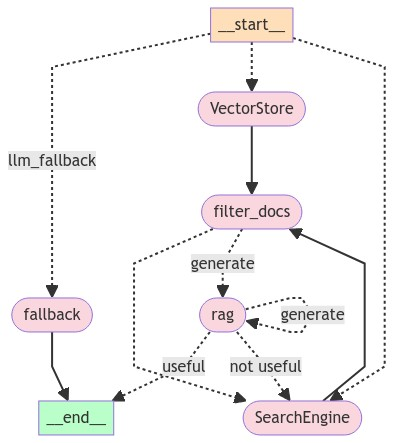

In [183]:
from io import BytesIO
from PIL import Image
from IPython.display import display

# Assuming you have the byte image stream in the 'byte_image' variable
img = Image.open(BytesIO(plot))
display(img)

<div style="
  font-size: 1em;
  color: #333;
  background-color: #f2f2f2;
  padding: 10px;
  border-radius: 10px;
  margin: 20px;
  animation: fadeIn 1s ease-in-out;
  width: 200px;
">
    <h1>9. Testing</h1>
</div>

In [188]:
for token in app.stream({"query": "What are the risk factors of migraines", "chat_history": []}):
    print(token, end="", flush=True)

---Routing to VectorStore---
{'VectorStore': {'documents': [Document(page_content="members who get them. If one parent has a history of thesetypes of headaches, you have a 50% chance of getting them. If both parents have them, the risk jumps to 75%.Other medical conditions.Depression,\xa0anxiety,bipolar disorder,sleep disorders, andepilepsycan raise your odds.Migraine TriggersSome things that may trigger an attack\xa0include:Hormone changes.You maynotice that you have headaches around your period, while you'repregnant, or when you'reovulating. Symptoms may also be tied to", metadata={'description': 'Migraine headaches, also known as migraines, are a type of headache that can cause debilitating pain. Learn more about the types, causes, symptoms, diagnosis, & treatment of migraines.', 'language': 'en', 'source': 'https://www.webmd.com/migraines-headaches/migraines-headaches-migraines', 'title': 'Migraine: Symptoms, Causes, and Treatment'}), Document(page_content="members who get them. If

In [189]:
response = app.invoke({"query": "What are the symptoms of hypertension", "chat_history": []})
Markdown(response["generation"])

---Routing to SearchEngine---
---CHUCK 1: RELEVANT---
---CHUCK 2: NOT RELEVANT---
---CHUCK 3: RELEVANT---
---CHUCK 4: RELEVANT---
---CHUCK 5: RELEVANT---
---Some retrived documents are relevant---
---Hallucination check passed---
---Answer is relevant to question---



Based on the provided context, the symptoms of hypertension mentioned are:

* Shortness of breath
* Dizziness
* Headaches
* Nosebleeds
* Frequent headaches
* Recurrent dizziness
* Nausea or vomiting

It's worth noting that high blood pressure often doesn't cause symptoms, and many people with hypertension may not experience any symptoms at all. However, if symptoms do occur, they can be severe and require immediate medical attention.

In [ ]:
import gradio as gr
from uuid import uuid4

history = {}
session_id = str(uuid4())

def chat(query):

    # Initialize the chat history for the current session
    if session_id not in history:
        history[session_id] = []

    chat_history = history[session_id]

    # Invoke the app with the current query and chat history
    result = app.invoke({"query": query, "chat_history": chat_history})

    # Separate the response from the retrieved documents
    response = result["generation"]
    documents = result["documents"]

    # Add the current exchange to the chat history
    chat_history.extend([HumanMessage(content=query), AIMessage(content=response)])

    if not documents:
        return response, documents

    documents = [
        f"{doc.page_content}\nsource: {doc.metadata['source']}" for doc in documents
    ]

    return response, "\n\n".join(documents)

# Create the Gradio interface
demo = gr.Interface(
    fn=chat,
    inputs=gr.Textbox(label="Question"),
    outputs=[gr.Textbox(label="Response"), gr.Textbox(label="Retrieved Documents")],
    title="RAG Chatbot",
    description="Ask a health-related query and the chatbot will generate a response using Retrieval Augmented Generation.",
)

if __name__ == "__main__":
    demo.launch(share=True, inline=True)

## Reference:
- https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_adaptive_rag_cohere.ipynb

<h3 style="text-align: center; color: #333; background-color: #f0f0f0; border-radius: 8px; border: 1px solid #ccc; padding: 10px; width: 150px;">Thank you</h3>